<h3>导入包</h3>

In [105]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [106]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [107]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)

<h4>读入C榜数据</h4>

In [108]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_Final/' + name + '_EC_Final.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.085938
 668 2015-08-17 23:00:00  0.128906
 669 2015-08-17 23:15:00  0.082031
 670 2015-08-17 23:30:00  0.144531
 671 2015-08-17 23:45:00  0.093750
 
 [64744 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.000000
 668 2015-08-17 23:00:00  0.000000
 669 2015-08-17 23:15:00  0.000000
 670 2015-08-17 23:30:00  0.000000
 671 2015-08-17 23:45:00  0.000000
 
 [64992 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [109]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [110]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
64504,2015-08-17 22:45:00,0.085938,0.000000,0.089844,0.265625,1.937500
64505,2015-08-17 23:00:00,0.128906,0.000000,0.140625,0.265625,1.750000
64506,2015-08-17 23:15:00,0.082031,0.000000,0.093750,0.265625,1.843750
64507,2015-08-17 23:30:00,0.144531,0.000000,0.156250,0.265625,1.687500


<h4>将一二层数据相加</h4>

In [111]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [112]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [113]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [114]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [115]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [116]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-17 19:00:00,8.187500,1.015625,1.187500,10.390625
2015-08-17 20:00:00,8.031250,1.000000,0.937500,9.968750
2015-08-17 21:00:00,8.656250,1.007812,1.046875,10.710938
2015-08-17 22:00:00,7.468750,0.949219,1.156250,9.574219


<AxesSubplot:>

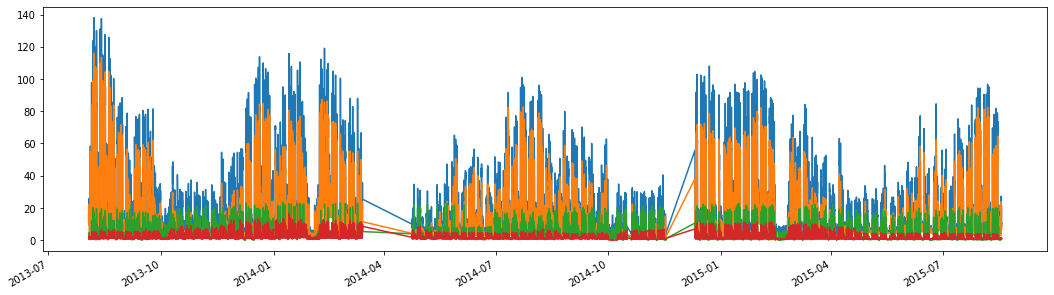

In [117]:
data["value_total"].plot(figsize=(18,5))
data["value_air"].plot(figsize=(18,5))
data["value_light"].plot(figsize=(18,5))
data["value_socket"].plot(figsize=(18,5))

<h3>合并天气数据</h3>

In [118]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [119]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [120]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["date"] = list(map(lambda x: x.date(), data.index.to_list()))
data["wind_angle"] = data["wind_angle"].apply(lambda x: np.cos(np.pi / 180 * x))
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)

mean_weather = data[["date", "temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]].groupby("date").mean()
sum_weather = data[["date", "rainfall"]].groupby("date").sum()
data = pd.merge(data.drop(columns=["temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]), mean_weather, how="inner", left_on="date", right_index=True)
data = pd.merge(data.drop(columns=["rainfall"]), sum_weather, how="inner", left_on="date", right_index=True)
data = data.drop(columns=["date"])

# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,wind_direction,workday,hour,week,day,month,year,is_summer,is_winter,temp,humidity,atmos,wind_angle,wind_speed,cloud,rainfall
time,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,东南风,0,0,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,东南风,0,1,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,东南风,0,2,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,东南风,0,3,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,东南风,0,4,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,东北风,1,19,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,东北风,1,20,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,东北风,1,21,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [121]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,workday,hour,week,day,month,year,...,cloud,rainfall,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,0,0,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,0,1,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,0,2,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,0,3,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,0,4,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,1,19,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,1,20,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,1,21,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [122]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,workday,hour,day,month,year,is_summer,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,0,0,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,0,1,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,0,2,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,0,3,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,0,4,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,1,19,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,1,20,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,1,21,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [123]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [124]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_metric(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))[1]
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [125]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [126]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [127]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [128]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

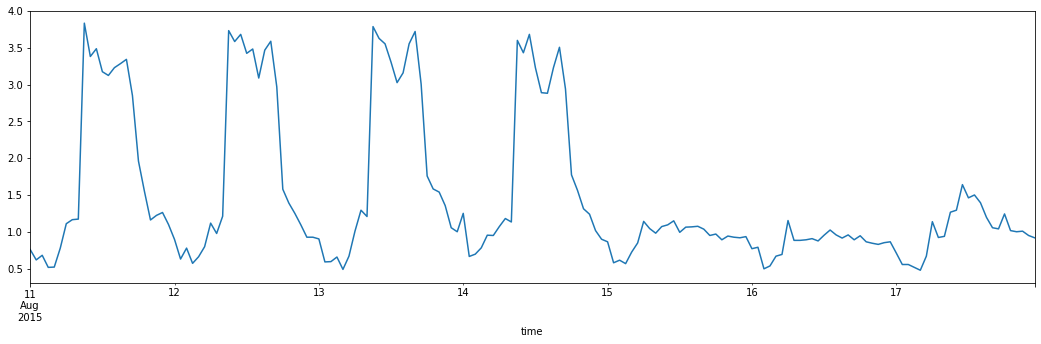

In [129]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [130]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [131]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [132]:
socket_pred2 = data_socket.loc[: "2015-08-10 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [133]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063462
0:	learn: 1.9021190	total: 66.7ms	remaining: 1m 6s
1:	learn: 1.8126397	total: 68.8ms	remaining: 34.3s
2:	learn: 1.7295371	total: 70.9ms	remaining: 23.6s
3:	learn: 1.6531055	total: 72.9ms	remaining: 18.2s
4:	learn: 1.5829596	total: 75ms	remaining: 14.9s
5:	learn: 1.5172177	total: 77ms	remaining: 12.8s
6:	learn: 1.4583006	total: 79ms	remaining: 11.2s
7:	learn: 1.4022904	total: 80.9ms	remaining: 10s
8:	learn: 1.3519502	total: 82.9ms	remaining: 9.12s
9:	learn: 1.3051437	total: 84.8ms	remaining: 8.4s
10:	learn: 1.2625295	total: 86.9ms	remaining: 7.81s
11:	learn: 1.2236371	total: 88.9ms	remaining: 7.32s
12:	learn: 1.1882331	total: 90.8ms	remaining: 6.89s
13:	learn: 1.1562660	total: 92.7ms	remaining: 6.53s
14:	learn: 1.1265692	total: 94.7ms	remaining: 6.22s
15:	learn: 1.0996298	total: 96.7ms	remaining: 5.94s
16:	learn: 1.0749785	total: 98.6ms	remaining: 5.7s
17:	learn: 1.0521629	total: 101ms	remaining: 5.49s
18:	learn: 1.0322155	total: 103ms	remaining: 5.29s
19:	

228:	learn: 0.5684609	total: 522ms	remaining: 1.76s
229:	learn: 0.5679028	total: 524ms	remaining: 1.75s
230:	learn: 0.5675195	total: 526ms	remaining: 1.75s
231:	learn: 0.5670412	total: 528ms	remaining: 1.75s
232:	learn: 0.5664902	total: 530ms	remaining: 1.74s
233:	learn: 0.5661223	total: 532ms	remaining: 1.74s
234:	learn: 0.5655871	total: 534ms	remaining: 1.74s
235:	learn: 0.5650109	total: 536ms	remaining: 1.73s
236:	learn: 0.5646817	total: 538ms	remaining: 1.73s
237:	learn: 0.5642018	total: 540ms	remaining: 1.73s
238:	learn: 0.5638802	total: 542ms	remaining: 1.73s
239:	learn: 0.5633782	total: 544ms	remaining: 1.72s
240:	learn: 0.5629002	total: 546ms	remaining: 1.72s
241:	learn: 0.5624925	total: 548ms	remaining: 1.72s
242:	learn: 0.5619308	total: 550ms	remaining: 1.71s
243:	learn: 0.5616243	total: 552ms	remaining: 1.71s
244:	learn: 0.5611233	total: 554ms	remaining: 1.71s
245:	learn: 0.5608763	total: 556ms	remaining: 1.7s
246:	learn: 0.5604313	total: 558ms	remaining: 1.7s
247:	learn: 0.

407:	learn: 0.5032268	total: 881ms	remaining: 1.28s
408:	learn: 0.5030320	total: 883ms	remaining: 1.27s
409:	learn: 0.5026903	total: 885ms	remaining: 1.27s
410:	learn: 0.5025009	total: 887ms	remaining: 1.27s
411:	learn: 0.5023397	total: 889ms	remaining: 1.27s
412:	learn: 0.5019776	total: 891ms	remaining: 1.27s
413:	learn: 0.5017484	total: 893ms	remaining: 1.26s
414:	learn: 0.5014275	total: 895ms	remaining: 1.26s
415:	learn: 0.5011950	total: 898ms	remaining: 1.26s
416:	learn: 0.5009795	total: 900ms	remaining: 1.26s
417:	learn: 0.5007340	total: 902ms	remaining: 1.26s
418:	learn: 0.5005717	total: 905ms	remaining: 1.25s
419:	learn: 0.5001857	total: 907ms	remaining: 1.25s
420:	learn: 0.4999300	total: 909ms	remaining: 1.25s
421:	learn: 0.4995445	total: 911ms	remaining: 1.25s
422:	learn: 0.4993532	total: 913ms	remaining: 1.25s
423:	learn: 0.4991705	total: 915ms	remaining: 1.24s
424:	learn: 0.4988751	total: 917ms	remaining: 1.24s
425:	learn: 0.4986054	total: 919ms	remaining: 1.24s
426:	learn: 

585:	learn: 0.4661095	total: 1.24s	remaining: 878ms
586:	learn: 0.4659492	total: 1.24s	remaining: 876ms
587:	learn: 0.4658079	total: 1.25s	remaining: 874ms
588:	learn: 0.4656509	total: 1.25s	remaining: 871ms
589:	learn: 0.4655798	total: 1.25s	remaining: 869ms
590:	learn: 0.4654940	total: 1.25s	remaining: 867ms
591:	learn: 0.4653327	total: 1.25s	remaining: 865ms
592:	learn: 0.4651482	total: 1.26s	remaining: 863ms
593:	learn: 0.4650303	total: 1.26s	remaining: 860ms
594:	learn: 0.4649081	total: 1.26s	remaining: 858ms
595:	learn: 0.4646686	total: 1.26s	remaining: 856ms
596:	learn: 0.4645291	total: 1.26s	remaining: 854ms
597:	learn: 0.4643617	total: 1.27s	remaining: 852ms
598:	learn: 0.4641742	total: 1.27s	remaining: 849ms
599:	learn: 0.4640487	total: 1.27s	remaining: 847ms
600:	learn: 0.4639135	total: 1.27s	remaining: 845ms
601:	learn: 0.4637746	total: 1.27s	remaining: 843ms
602:	learn: 0.4636440	total: 1.28s	remaining: 841ms
603:	learn: 0.4634417	total: 1.28s	remaining: 838ms
604:	learn: 

761:	learn: 0.4398232	total: 1.6s	remaining: 500ms
762:	learn: 0.4397227	total: 1.6s	remaining: 498ms
763:	learn: 0.4395817	total: 1.61s	remaining: 496ms
764:	learn: 0.4394422	total: 1.61s	remaining: 494ms
765:	learn: 0.4393281	total: 1.61s	remaining: 492ms
766:	learn: 0.4392136	total: 1.61s	remaining: 490ms
767:	learn: 0.4391018	total: 1.61s	remaining: 488ms
768:	learn: 0.4388805	total: 1.62s	remaining: 486ms
769:	learn: 0.4387554	total: 1.62s	remaining: 484ms
770:	learn: 0.4386482	total: 1.62s	remaining: 481ms
771:	learn: 0.4385294	total: 1.62s	remaining: 479ms
772:	learn: 0.4384008	total: 1.63s	remaining: 477ms
773:	learn: 0.4383248	total: 1.63s	remaining: 475ms
774:	learn: 0.4381637	total: 1.63s	remaining: 473ms
775:	learn: 0.4380045	total: 1.63s	remaining: 471ms
776:	learn: 0.4379404	total: 1.63s	remaining: 469ms
777:	learn: 0.4377819	total: 1.64s	remaining: 467ms
778:	learn: 0.4376528	total: 1.64s	remaining: 464ms
779:	learn: 0.4374896	total: 1.64s	remaining: 462ms
780:	learn: 0.

941:	learn: 0.4192018	total: 1.96s	remaining: 121ms
942:	learn: 0.4191060	total: 1.97s	remaining: 119ms
943:	learn: 0.4189786	total: 1.97s	remaining: 117ms
944:	learn: 0.4188185	total: 1.97s	remaining: 115ms
945:	learn: 0.4187531	total: 1.97s	remaining: 113ms
946:	learn: 0.4186503	total: 1.97s	remaining: 110ms
947:	learn: 0.4185799	total: 1.98s	remaining: 108ms
948:	learn: 0.4185469	total: 1.98s	remaining: 106ms
949:	learn: 0.4184841	total: 1.98s	remaining: 104ms
950:	learn: 0.4183504	total: 1.98s	remaining: 102ms
951:	learn: 0.4182592	total: 1.98s	remaining: 100ms
952:	learn: 0.4181239	total: 1.99s	remaining: 98ms
953:	learn: 0.4180710	total: 1.99s	remaining: 95.9ms
954:	learn: 0.4179532	total: 1.99s	remaining: 93.8ms
955:	learn: 0.4178072	total: 1.99s	remaining: 91.7ms
956:	learn: 0.4176505	total: 1.99s	remaining: 89.6ms
957:	learn: 0.4175200	total: 2s	remaining: 87.5ms
958:	learn: 0.4174270	total: 2s	remaining: 85.4ms
959:	learn: 0.4173589	total: 2s	remaining: 83.3ms
960:	learn: 0.4

<h5>构建xgboost</h5>

In [134]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [135]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
125/125 [==============================] - 11s 44ms/step - loss: 6.7708 - mae: 1.8580
Epoch 2/100
125/125 [==============================] - 5s 39ms/step - loss: 1.6423 - mae: 0.8272
Epoch 3/100
125/125 [==============================] - 5s 39ms/step - loss: 1.2804 - mae: 0.7261
Epoch 4/100
125/125 [==============================] - 5s 39ms/step - loss: 1.1251 - mae: 0.6813
Epoch 5/100
125/125 [==============================] - 5s 39ms/step - loss: 0.9977 - mae: 0.6406
Epoch 6/100
125/125 [==============================] - 5s 39ms/step - loss: 0.9140 - mae: 0.6111
Epoch 7/100
125/125 [==============================] - 5s 39ms/step - loss: 0.8533 - mae: 0.5877
Epoch 8/100
125/125 [==============================] - 5s 39ms/step - loss: 0.7638 - mae: 0.5543
Epoch 9/100
125/125 [==============================] - 5s 39ms/step - loss: 0.7048 - mae: 0.5313
Epoch 10/100
125/125 [==============================] - 5s 39ms/step - loss: 0.6306 - mae: 0.5027
Epoch 11/100
125/125 [======

125/125 [==============================] - 5s 40ms/step - loss: 0.0661 - mae: 0.1605
Epoch 85/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0593 - mae: 0.1523
Epoch 86/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0569 - mae: 0.1489
Epoch 87/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0552 - mae: 0.1470
Epoch 88/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0547 - mae: 0.1452
Epoch 89/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0563 - mae: 0.1478
Epoch 90/100
125/125 [==============================] - 5s 40ms/step - loss: 0.0531 - mae: 0.1432
Epoch 91/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0530 - mae: 0.1426
Epoch 92/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0536 - mae: 0.1439
Epoch 93/100
125/125 [==============================] - 5s 41ms/step - loss: 0.0541 - mae: 0.1444
Epoch 94/100
125/125 [===========

2023-04-26 10:33:37,589 [INFO] saving LSTM model to ../models/LSTM_socket_final.h5


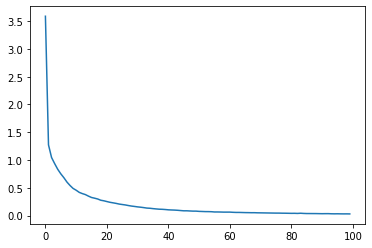

In [136]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket_final.h5")
except (OSError, ValueError) as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [137]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

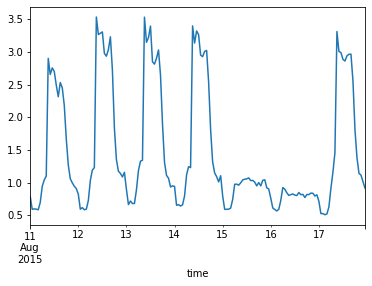

In [138]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4 + socket_pred5) / 5
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

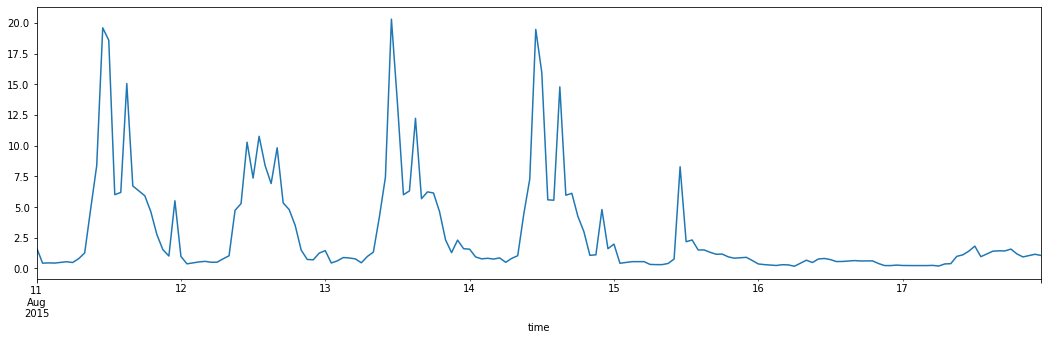

In [139]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [140]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [141]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [142]:
light_pred2 = data_light.loc[: "2015-08-10 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [143]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063462
0:	learn: 3.5540881	total: 3.28ms	remaining: 3.28s
1:	learn: 3.3893379	total: 6.22ms	remaining: 3.1s
2:	learn: 3.2378582	total: 9.1ms	remaining: 3.02s
3:	learn: 3.0988288	total: 12ms	remaining: 3s
4:	learn: 2.9714656	total: 14.8ms	remaining: 2.95s
5:	learn: 2.8552029	total: 17.8ms	remaining: 2.94s
6:	learn: 2.7462927	total: 20.6ms	remaining: 2.92s
7:	learn: 2.6491827	total: 23.4ms	remaining: 2.9s
8:	learn: 2.5585888	total: 26.2ms	remaining: 2.88s
9:	learn: 2.4750524	total: 29ms	remaining: 2.87s
10:	learn: 2.3994791	total: 31.7ms	remaining: 2.85s
11:	learn: 2.3320206	total: 34.5ms	remaining: 2.84s
12:	learn: 2.2687804	total: 37.2ms	remaining: 2.82s
13:	learn: 2.2078399	total: 40ms	remaining: 2.82s
14:	learn: 2.1514234	total: 43ms	remaining: 2.82s
15:	learn: 2.1065493	total: 45.5ms	remaining: 2.8s
16:	learn: 2.0580619	total: 48.3ms	remaining: 2.79s
17:	learn: 2.0164637	total: 51.1ms	remaining: 2.79s
18:	learn: 1.9787386	total: 53.8ms	remaining: 2.78s
19:	lea

216:	learn: 1.3072795	total: 527ms	remaining: 1.9s
217:	learn: 1.3064247	total: 529ms	remaining: 1.9s
218:	learn: 1.3057367	total: 532ms	remaining: 1.9s
219:	learn: 1.3047825	total: 534ms	remaining: 1.89s
220:	learn: 1.3039973	total: 536ms	remaining: 1.89s
221:	learn: 1.3031322	total: 539ms	remaining: 1.89s
222:	learn: 1.3021608	total: 541ms	remaining: 1.89s
223:	learn: 1.3015874	total: 544ms	remaining: 1.88s
224:	learn: 1.3005252	total: 546ms	remaining: 1.88s
225:	learn: 1.2994323	total: 548ms	remaining: 1.88s
226:	learn: 1.2983436	total: 551ms	remaining: 1.88s
227:	learn: 1.2976191	total: 553ms	remaining: 1.87s
228:	learn: 1.2966785	total: 555ms	remaining: 1.87s
229:	learn: 1.2961618	total: 558ms	remaining: 1.87s
230:	learn: 1.2954541	total: 560ms	remaining: 1.86s
231:	learn: 1.2945187	total: 563ms	remaining: 1.86s
232:	learn: 1.2936818	total: 565ms	remaining: 1.86s
233:	learn: 1.2929700	total: 567ms	remaining: 1.86s
234:	learn: 1.2920962	total: 570ms	remaining: 1.85s
235:	learn: 1.2

437:	learn: 1.1690581	total: 1.06s	remaining: 1.37s
438:	learn: 1.1687611	total: 1.07s	remaining: 1.36s
439:	learn: 1.1681754	total: 1.07s	remaining: 1.36s
440:	learn: 1.1677472	total: 1.07s	remaining: 1.36s
441:	learn: 1.1673380	total: 1.07s	remaining: 1.36s
442:	learn: 1.1670601	total: 1.08s	remaining: 1.35s
443:	learn: 1.1666042	total: 1.08s	remaining: 1.35s
444:	learn: 1.1662525	total: 1.08s	remaining: 1.35s
445:	learn: 1.1659691	total: 1.08s	remaining: 1.35s
446:	learn: 1.1646902	total: 1.09s	remaining: 1.34s
447:	learn: 1.1643677	total: 1.09s	remaining: 1.34s
448:	learn: 1.1639766	total: 1.09s	remaining: 1.34s
449:	learn: 1.1634601	total: 1.09s	remaining: 1.34s
450:	learn: 1.1629467	total: 1.1s	remaining: 1.33s
451:	learn: 1.1626304	total: 1.1s	remaining: 1.33s
452:	learn: 1.1623843	total: 1.1s	remaining: 1.33s
453:	learn: 1.1619586	total: 1.1s	remaining: 1.33s
454:	learn: 1.1614572	total: 1.1s	remaining: 1.32s
455:	learn: 1.1609967	total: 1.11s	remaining: 1.32s
456:	learn: 1.160

664:	learn: 1.0789534	total: 1.61s	remaining: 810ms
665:	learn: 1.0784964	total: 1.61s	remaining: 808ms
666:	learn: 1.0782269	total: 1.61s	remaining: 805ms
667:	learn: 1.0780723	total: 1.61s	remaining: 803ms
668:	learn: 1.0778818	total: 1.62s	remaining: 800ms
669:	learn: 1.0776050	total: 1.62s	remaining: 798ms
670:	learn: 1.0774049	total: 1.62s	remaining: 796ms
671:	learn: 1.0770766	total: 1.63s	remaining: 793ms
672:	learn: 1.0767978	total: 1.63s	remaining: 791ms
673:	learn: 1.0766139	total: 1.63s	remaining: 788ms
674:	learn: 1.0763399	total: 1.63s	remaining: 786ms
675:	learn: 1.0758372	total: 1.63s	remaining: 783ms
676:	learn: 1.0753822	total: 1.64s	remaining: 781ms
677:	learn: 1.0749842	total: 1.64s	remaining: 779ms
678:	learn: 1.0745193	total: 1.64s	remaining: 776ms
679:	learn: 1.0741048	total: 1.64s	remaining: 774ms
680:	learn: 1.0736368	total: 1.65s	remaining: 771ms
681:	learn: 1.0733168	total: 1.65s	remaining: 769ms
682:	learn: 1.0730913	total: 1.65s	remaining: 766ms
683:	learn: 

898:	learn: 1.0097784	total: 2.15s	remaining: 241ms
899:	learn: 1.0094436	total: 2.15s	remaining: 239ms
900:	learn: 1.0090610	total: 2.15s	remaining: 237ms
901:	learn: 1.0088561	total: 2.16s	remaining: 234ms
902:	learn: 1.0087447	total: 2.16s	remaining: 232ms
903:	learn: 1.0085807	total: 2.16s	remaining: 230ms
904:	learn: 1.0082424	total: 2.16s	remaining: 227ms
905:	learn: 1.0080469	total: 2.17s	remaining: 225ms
906:	learn: 1.0078449	total: 2.17s	remaining: 222ms
907:	learn: 1.0075980	total: 2.17s	remaining: 220ms
908:	learn: 1.0071872	total: 2.17s	remaining: 218ms
909:	learn: 1.0068235	total: 2.17s	remaining: 215ms
910:	learn: 1.0064204	total: 2.18s	remaining: 213ms
911:	learn: 1.0062023	total: 2.18s	remaining: 210ms
912:	learn: 1.0059835	total: 2.18s	remaining: 208ms
913:	learn: 1.0058583	total: 2.18s	remaining: 206ms
914:	learn: 1.0056455	total: 2.19s	remaining: 203ms
915:	learn: 1.0054081	total: 2.19s	remaining: 201ms
916:	learn: 1.0051332	total: 2.19s	remaining: 198ms
917:	learn: 

<h5>构建xgboost</h5>

In [144]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [145]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
125/125 [==============================] - 8s 44ms/step - loss: 23.3151 - mae: 3.4272
Epoch 2/100
125/125 [==============================] - 5s 38ms/step - loss: 6.9185 - mae: 1.6728
Epoch 3/100
125/125 [==============================] - 5s 38ms/step - loss: 5.3028 - mae: 1.4495
Epoch 4/100
125/125 [==============================] - 5s 38ms/step - loss: 4.6309 - mae: 1.3599
Epoch 5/100
125/125 [==============================] - 5s 39ms/step - loss: 4.2002 - mae: 1.2996
Epoch 6/100
125/125 [==============================] - 5s 39ms/step - loss: 3.8123 - mae: 1.2398
Epoch 7/100
125/125 [==============================] - 5s 39ms/step - loss: 3.5618 - mae: 1.2009
Epoch 8/100
125/125 [==============================] - 5s 39ms/step - loss: 3.2979 - mae: 1.1571
Epoch 9/100
125/125 [==============================] - 5s 39ms/step - loss: 3.1320 - mae: 1.1276
Epoch 10/100
125/125 [==============================] - 5s 39ms/step - loss: 2.9314 - mae: 1.0944
Epoch 11/100
125/125 [======

125/125 [==============================] - 5s 39ms/step - loss: 0.2590 - mae: 0.2899
Epoch 85/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2420 - mae: 0.2769
Epoch 86/100
125/125 [==============================] - 5s 40ms/step - loss: 0.2391 - mae: 0.2764
Epoch 87/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2419 - mae: 0.2783
Epoch 88/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2315 - mae: 0.2703
Epoch 89/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2394 - mae: 0.2738
Epoch 90/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2302 - mae: 0.2692
Epoch 91/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2314 - mae: 0.2704
Epoch 92/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2271 - mae: 0.2660
Epoch 93/100
125/125 [==============================] - 5s 39ms/step - loss: 0.2322 - mae: 0.2718
Epoch 94/100
125/125 [===========

2023-04-26 10:42:01,593 [INFO] saving LSTM model to ../models/LSTM_light_final.h5


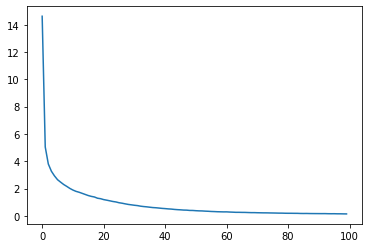

In [146]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_light_final.h5")
except (OSError, ValueError) as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_light_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [147]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

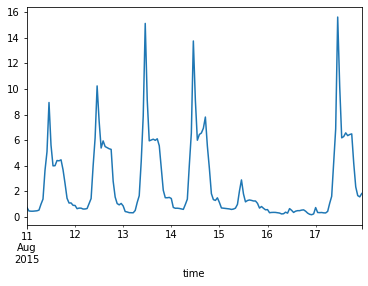

In [148]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4 + light_pred5) / 5
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

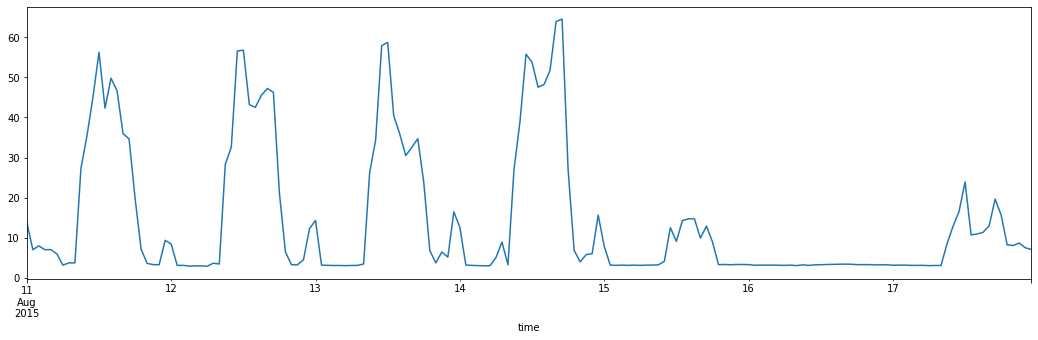

In [149]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [150]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [151]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [152]:
air_pred2 = data_air.loc[: "2015-08-10 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [153]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063462
0:	learn: 14.1219252	total: 3.46ms	remaining: 3.45s
1:	learn: 13.5629992	total: 6.6ms	remaining: 3.29s
2:	learn: 13.0535653	total: 9.56ms	remaining: 3.18s
3:	learn: 12.5761175	total: 12.6ms	remaining: 3.15s
4:	learn: 12.1192898	total: 15.5ms	remaining: 3.09s
5:	learn: 11.7115226	total: 18.6ms	remaining: 3.08s
6:	learn: 11.3453532	total: 21.4ms	remaining: 3.04s
7:	learn: 11.0140004	total: 24.3ms	remaining: 3.01s
8:	learn: 10.6898685	total: 27.3ms	remaining: 3.01s
9:	learn: 10.3979704	total: 30.2ms	remaining: 2.99s
10:	learn: 10.1300857	total: 33.2ms	remaining: 2.98s
11:	learn: 9.8844832	total: 36.1ms	remaining: 2.97s
12:	learn: 9.6610335	total: 39ms	remaining: 2.96s
13:	learn: 9.4508369	total: 41.9ms	remaining: 2.95s
14:	learn: 9.2570145	total: 44.7ms	remaining: 2.94s
15:	learn: 9.0886974	total: 47.7ms	remaining: 2.93s
16:	learn: 8.9277281	total: 50.5ms	remaining: 2.92s
17:	learn: 8.7845241	total: 53.4ms	remaining: 2.91s
18:	learn: 8.6553853	total: 56.3ms	r

207:	learn: 4.9319073	total: 536ms	remaining: 2.04s
208:	learn: 4.9232751	total: 538ms	remaining: 2.04s
209:	learn: 4.9185243	total: 541ms	remaining: 2.03s
210:	learn: 4.9122679	total: 543ms	remaining: 2.03s
211:	learn: 4.9052659	total: 546ms	remaining: 2.03s
212:	learn: 4.8959912	total: 549ms	remaining: 2.03s
213:	learn: 4.8908223	total: 551ms	remaining: 2.02s
214:	learn: 4.8863422	total: 554ms	remaining: 2.02s
215:	learn: 4.8807629	total: 556ms	remaining: 2.02s
216:	learn: 4.8733035	total: 559ms	remaining: 2.02s
217:	learn: 4.8686205	total: 561ms	remaining: 2.01s
218:	learn: 4.8637539	total: 564ms	remaining: 2.01s
219:	learn: 4.8582594	total: 566ms	remaining: 2.01s
220:	learn: 4.8546906	total: 568ms	remaining: 2s
221:	learn: 4.8477948	total: 571ms	remaining: 2s
222:	learn: 4.8437153	total: 574ms	remaining: 2s
223:	learn: 4.8392406	total: 576ms	remaining: 2s
224:	learn: 4.8363441	total: 578ms	remaining: 1.99s
225:	learn: 4.8327349	total: 581ms	remaining: 1.99s
226:	learn: 4.8251439	to

421:	learn: 4.0681150	total: 1.08s	remaining: 1.48s
422:	learn: 4.0663087	total: 1.08s	remaining: 1.47s
423:	learn: 4.0628005	total: 1.08s	remaining: 1.47s
424:	learn: 4.0606522	total: 1.08s	remaining: 1.47s
425:	learn: 4.0583078	total: 1.09s	remaining: 1.47s
426:	learn: 4.0547971	total: 1.09s	remaining: 1.46s
427:	learn: 4.0527272	total: 1.09s	remaining: 1.46s
428:	learn: 4.0500979	total: 1.09s	remaining: 1.46s
429:	learn: 4.0469445	total: 1.1s	remaining: 1.46s
430:	learn: 4.0446708	total: 1.1s	remaining: 1.45s
431:	learn: 4.0429085	total: 1.1s	remaining: 1.45s
432:	learn: 4.0402579	total: 1.1s	remaining: 1.45s
433:	learn: 4.0375788	total: 1.11s	remaining: 1.44s
434:	learn: 4.0361487	total: 1.11s	remaining: 1.44s
435:	learn: 4.0343857	total: 1.11s	remaining: 1.44s
436:	learn: 4.0318831	total: 1.11s	remaining: 1.44s
437:	learn: 4.0298222	total: 1.12s	remaining: 1.43s
438:	learn: 4.0274372	total: 1.12s	remaining: 1.43s
439:	learn: 4.0246101	total: 1.12s	remaining: 1.43s
440:	learn: 4.02

637:	learn: 3.6122078	total: 1.62s	remaining: 919ms
638:	learn: 3.6096339	total: 1.62s	remaining: 916ms
639:	learn: 3.6076701	total: 1.62s	remaining: 914ms
640:	learn: 3.6046047	total: 1.63s	remaining: 911ms
641:	learn: 3.6034611	total: 1.63s	remaining: 909ms
642:	learn: 3.6009184	total: 1.63s	remaining: 906ms
643:	learn: 3.5985745	total: 1.63s	remaining: 904ms
644:	learn: 3.5961567	total: 1.64s	remaining: 901ms
645:	learn: 3.5947624	total: 1.64s	remaining: 898ms
646:	learn: 3.5935219	total: 1.64s	remaining: 896ms
647:	learn: 3.5918548	total: 1.64s	remaining: 893ms
648:	learn: 3.5902477	total: 1.65s	remaining: 891ms
649:	learn: 3.5891438	total: 1.65s	remaining: 888ms
650:	learn: 3.5868930	total: 1.65s	remaining: 886ms
651:	learn: 3.5858411	total: 1.65s	remaining: 883ms
652:	learn: 3.5822512	total: 1.66s	remaining: 881ms
653:	learn: 3.5807533	total: 1.66s	remaining: 878ms
654:	learn: 3.5786479	total: 1.66s	remaining: 875ms
655:	learn: 3.5750548	total: 1.66s	remaining: 873ms
656:	learn: 

855:	learn: 3.3033220	total: 2.16s	remaining: 364ms
856:	learn: 3.3013136	total: 2.16s	remaining: 361ms
857:	learn: 3.3002782	total: 2.17s	remaining: 359ms
858:	learn: 3.2996356	total: 2.17s	remaining: 356ms
859:	learn: 3.2978221	total: 2.17s	remaining: 354ms
860:	learn: 3.2967631	total: 2.17s	remaining: 351ms
861:	learn: 3.2956485	total: 2.18s	remaining: 348ms
862:	learn: 3.2932629	total: 2.18s	remaining: 346ms
863:	learn: 3.2922999	total: 2.18s	remaining: 343ms
864:	learn: 3.2914486	total: 2.18s	remaining: 341ms
865:	learn: 3.2901209	total: 2.19s	remaining: 338ms
866:	learn: 3.2890165	total: 2.19s	remaining: 336ms
867:	learn: 3.2874928	total: 2.19s	remaining: 333ms
868:	learn: 3.2864799	total: 2.19s	remaining: 331ms
869:	learn: 3.2852522	total: 2.2s	remaining: 328ms
870:	learn: 3.2844374	total: 2.2s	remaining: 326ms
871:	learn: 3.2827141	total: 2.2s	remaining: 323ms
872:	learn: 3.2817990	total: 2.2s	remaining: 321ms
873:	learn: 3.2810316	total: 2.21s	remaining: 318ms
874:	learn: 3.27

<h5>构建xgboost</h5>

In [154]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [155]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
125/125 [==============================] - 8s 45ms/step - loss: 433.3874 - mae: 13.4883
Epoch 2/100
125/125 [==============================] - 5s 40ms/step - loss: 299.4154 - mae: 11.5901
Epoch 3/100
125/125 [==============================] - 5s 40ms/step - loss: 220.2028 - mae: 9.6162
Epoch 4/100
125/125 [==============================] - 5s 40ms/step - loss: 146.2728 - mae: 7.6996
Epoch 5/100
125/125 [==============================] - 5s 41ms/step - loss: 116.4828 - mae: 6.6395
Epoch 6/100
125/125 [==============================] - 5s 41ms/step - loss: 100.4156 - mae: 6.1217
Epoch 7/100
125/125 [==============================] - 5s 40ms/step - loss: 87.1380 - mae: 5.7366
Epoch 8/100
125/125 [==============================] - 5s 40ms/step - loss: 73.9653 - mae: 5.3031
Epoch 9/100
125/125 [==============================] - 5s 40ms/step - loss: 66.2990 - mae: 5.0066
Epoch 10/100
125/125 [==============================] - 5s 41ms/step - loss: 58.5610 - mae: 4.7107
Epoch 11/10

125/125 [==============================] - 5s 41ms/step - loss: 4.2986 - mae: 1.2035
Epoch 85/100
125/125 [==============================] - 5s 40ms/step - loss: 3.9282 - mae: 1.1535
Epoch 86/100
125/125 [==============================] - 5s 41ms/step - loss: 3.8427 - mae: 1.1348
Epoch 87/100
125/125 [==============================] - 5s 41ms/step - loss: 3.7569 - mae: 1.1244
Epoch 88/100
125/125 [==============================] - 5s 41ms/step - loss: 3.7250 - mae: 1.1106
Epoch 89/100
125/125 [==============================] - 5s 41ms/step - loss: 3.6601 - mae: 1.0946
Epoch 90/100
125/125 [==============================] - 5s 41ms/step - loss: 3.6185 - mae: 1.0855
Epoch 91/100
125/125 [==============================] - 5s 41ms/step - loss: 3.5256 - mae: 1.0767
Epoch 92/100
125/125 [==============================] - 5s 41ms/step - loss: 3.3956 - mae: 1.0575
Epoch 93/100
125/125 [==============================] - 5s 41ms/step - loss: 3.5333 - mae: 1.0844
Epoch 94/100
125/125 [===========

2023-04-26 10:50:45,228 [INFO] saving LSTM model to ../models/LSTM_air_final.h5


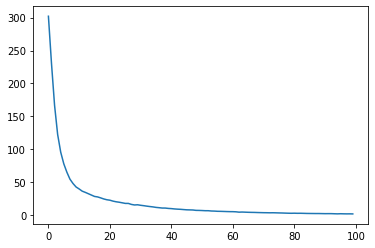

In [156]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_air_final.h5")
except (OSError, ValueError) as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_air5.save_weights("../models/LSTM_air_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_air_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [157]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

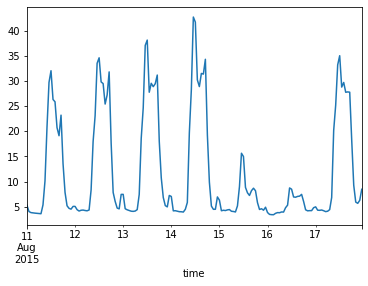

In [158]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4 + air_pred5) / 5
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

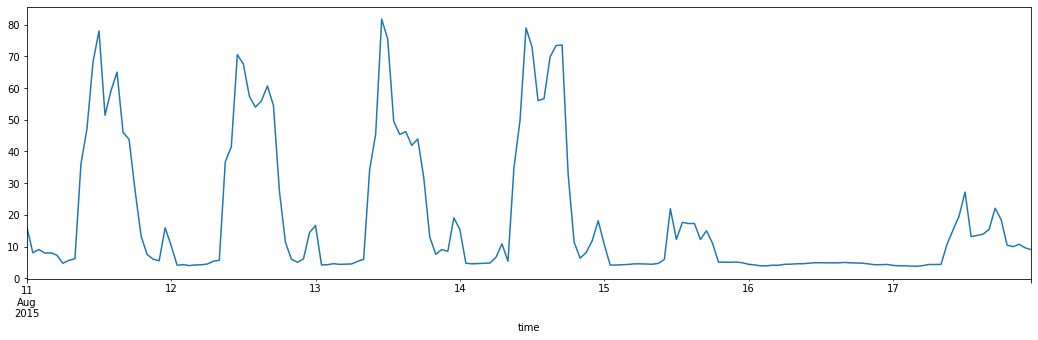

In [159]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [160]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [161]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [162]:
total_pred2 = data_total.loc[: "2015-08-10 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [163]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063462
0:	learn: 17.9541345	total: 3.74ms	remaining: 3.73s
1:	learn: 17.1668572	total: 6.89ms	remaining: 3.44s
2:	learn: 16.4419627	total: 10.1ms	remaining: 3.35s
3:	learn: 15.7720381	total: 13ms	remaining: 3.25s
4:	learn: 15.1575358	total: 16ms	remaining: 3.19s
5:	learn: 14.5964288	total: 19ms	remaining: 3.14s
6:	learn: 14.0740599	total: 21.9ms	remaining: 3.11s
7:	learn: 13.6070939	total: 24.9ms	remaining: 3.09s
8:	learn: 13.1636066	total: 27.9ms	remaining: 3.07s
9:	learn: 12.7600513	total: 30.8ms	remaining: 3.04s
10:	learn: 12.3902980	total: 33.8ms	remaining: 3.04s
11:	learn: 12.0467787	total: 36.7ms	remaining: 3.02s
12:	learn: 11.7297732	total: 39.8ms	remaining: 3.02s
13:	learn: 11.4498431	total: 42.7ms	remaining: 3.01s
14:	learn: 11.1953412	total: 45.7ms	remaining: 3s
15:	learn: 10.9662390	total: 48.6ms	remaining: 2.99s
16:	learn: 10.7478710	total: 51.5ms	remaining: 2.98s
17:	learn: 10.5461848	total: 54.7ms	remaining: 2.99s
18:	learn: 10.3652576	total: 57.5ms

201:	learn: 5.6435161	total: 538ms	remaining: 2.13s
202:	learn: 5.6384929	total: 541ms	remaining: 2.12s
203:	learn: 5.6318932	total: 543ms	remaining: 2.12s
204:	learn: 5.6234918	total: 546ms	remaining: 2.12s
205:	learn: 5.6164387	total: 549ms	remaining: 2.12s
206:	learn: 5.6079168	total: 551ms	remaining: 2.11s
207:	learn: 5.5996685	total: 554ms	remaining: 2.11s
208:	learn: 5.5936796	total: 557ms	remaining: 2.11s
209:	learn: 5.5857624	total: 559ms	remaining: 2.1s
210:	learn: 5.5819697	total: 562ms	remaining: 2.1s
211:	learn: 5.5702943	total: 564ms	remaining: 2.1s
212:	learn: 5.5625342	total: 566ms	remaining: 2.09s
213:	learn: 5.5576237	total: 569ms	remaining: 2.09s
214:	learn: 5.5532621	total: 571ms	remaining: 2.08s
215:	learn: 5.5449474	total: 574ms	remaining: 2.08s
216:	learn: 5.5387012	total: 576ms	remaining: 2.08s
217:	learn: 5.5347381	total: 579ms	remaining: 2.08s
218:	learn: 5.5286742	total: 581ms	remaining: 2.07s
219:	learn: 5.5236959	total: 584ms	remaining: 2.07s
220:	learn: 5.5

418:	learn: 4.6175462	total: 1.08s	remaining: 1.5s
419:	learn: 4.6140848	total: 1.08s	remaining: 1.5s
420:	learn: 4.6105692	total: 1.09s	remaining: 1.49s
421:	learn: 4.6084035	total: 1.09s	remaining: 1.49s
422:	learn: 4.6060636	total: 1.09s	remaining: 1.49s
423:	learn: 4.6037888	total: 1.09s	remaining: 1.49s
424:	learn: 4.6008178	total: 1.1s	remaining: 1.48s
425:	learn: 4.5992395	total: 1.1s	remaining: 1.48s
426:	learn: 4.5972108	total: 1.1s	remaining: 1.48s
427:	learn: 4.5940155	total: 1.1s	remaining: 1.48s
428:	learn: 4.5917787	total: 1.11s	remaining: 1.47s
429:	learn: 4.5892178	total: 1.11s	remaining: 1.47s
430:	learn: 4.5869463	total: 1.11s	remaining: 1.47s
431:	learn: 4.5833970	total: 1.11s	remaining: 1.46s
432:	learn: 4.5811960	total: 1.12s	remaining: 1.46s
433:	learn: 4.5770861	total: 1.12s	remaining: 1.46s
434:	learn: 4.5739191	total: 1.12s	remaining: 1.46s
435:	learn: 4.5723597	total: 1.12s	remaining: 1.45s
436:	learn: 4.5693171	total: 1.13s	remaining: 1.45s
437:	learn: 4.5659

628:	learn: 4.1267274	total: 1.62s	remaining: 957ms
629:	learn: 4.1228479	total: 1.63s	remaining: 955ms
630:	learn: 4.1212667	total: 1.63s	remaining: 953ms
631:	learn: 4.1186549	total: 1.63s	remaining: 950ms
632:	learn: 4.1166824	total: 1.63s	remaining: 948ms
633:	learn: 4.1143151	total: 1.64s	remaining: 945ms
634:	learn: 4.1121675	total: 1.64s	remaining: 943ms
635:	learn: 4.1111238	total: 1.64s	remaining: 940ms
636:	learn: 4.1099002	total: 1.65s	remaining: 938ms
637:	learn: 4.1091370	total: 1.65s	remaining: 936ms
638:	learn: 4.1064540	total: 1.65s	remaining: 933ms
639:	learn: 4.1036269	total: 1.66s	remaining: 931ms
640:	learn: 4.1024809	total: 1.66s	remaining: 928ms
641:	learn: 4.1016899	total: 1.66s	remaining: 926ms
642:	learn: 4.1007168	total: 1.66s	remaining: 924ms
643:	learn: 4.0984945	total: 1.67s	remaining: 921ms
644:	learn: 4.0958445	total: 1.67s	remaining: 919ms
645:	learn: 4.0949405	total: 1.67s	remaining: 916ms
646:	learn: 4.0925972	total: 1.68s	remaining: 914ms
647:	learn: 

837:	learn: 3.7780579	total: 2.16s	remaining: 418ms
838:	learn: 3.7769760	total: 2.16s	remaining: 415ms
839:	learn: 3.7758507	total: 2.17s	remaining: 413ms
840:	learn: 3.7745406	total: 2.17s	remaining: 410ms
841:	learn: 3.7731584	total: 2.17s	remaining: 408ms
842:	learn: 3.7718266	total: 2.17s	remaining: 405ms
843:	learn: 3.7688825	total: 2.18s	remaining: 402ms
844:	learn: 3.7682704	total: 2.18s	remaining: 400ms
845:	learn: 3.7674964	total: 2.18s	remaining: 397ms
846:	learn: 3.7661931	total: 2.19s	remaining: 395ms
847:	learn: 3.7653602	total: 2.19s	remaining: 392ms
848:	learn: 3.7643613	total: 2.19s	remaining: 390ms
849:	learn: 3.7625986	total: 2.19s	remaining: 387ms
850:	learn: 3.7606267	total: 2.19s	remaining: 384ms
851:	learn: 3.7598496	total: 2.2s	remaining: 382ms
852:	learn: 3.7587602	total: 2.2s	remaining: 379ms
853:	learn: 3.7575388	total: 2.2s	remaining: 377ms
854:	learn: 3.7557246	total: 2.21s	remaining: 374ms
855:	learn: 3.7546010	total: 2.21s	remaining: 371ms
856:	learn: 3.7

<h5>构建xgboost</h5>

In [164]:
model_total4 = XGBRegressor(n_estimators=1000, objective='reg:linear', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

[10:50:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


<h5>构建深度模型</h5>

In [165]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
125/125 [==============================] - 8s 47ms/step - loss: 731.8474 - mae: 18.3586
Epoch 2/100
125/125 [==============================] - 5s 40ms/step - loss: 312.4240 - mae: 10.8911
Epoch 3/100
125/125 [==============================] - 5s 40ms/step - loss: 139.5753 - mae: 7.4959
Epoch 4/100
125/125 [==============================] - 5s 40ms/step - loss: 101.8768 - mae: 6.4873
Epoch 5/100
125/125 [==============================] - 5s 41ms/step - loss: 88.0995 - mae: 6.0435
Epoch 6/100
125/125 [==============================] - 5s 41ms/step - loss: 73.6824 - mae: 5.5607
Epoch 7/100
125/125 [==============================] - 5s 41ms/step - loss: 64.9288 - mae: 5.2499
Epoch 8/100
125/125 [==============================] - 5s 42ms/step - loss: 55.8442 - mae: 4.8858
Epoch 9/100
125/125 [==============================] - 5s 41ms/step - loss: 49.4157 - mae: 4.6254
Epoch 10/100
125/125 [==============================] - 5s 41ms/step - loss: 44.1231 - mae: 4.3816
Epoch 11/100


125/125 [==============================] - 5s 40ms/step - loss: 5.0245 - mae: 1.3746
Epoch 85/100
125/125 [==============================] - 5s 41ms/step - loss: 4.4728 - mae: 1.3036
Epoch 86/100
125/125 [==============================] - 5s 41ms/step - loss: 4.3691 - mae: 1.2874
Epoch 87/100
125/125 [==============================] - 5s 44ms/step - loss: 4.4578 - mae: 1.3101
Epoch 88/100
125/125 [==============================] - 5s 41ms/step - loss: 4.2393 - mae: 1.2619
Epoch 89/100
125/125 [==============================] - 5s 41ms/step - loss: 4.1060 - mae: 1.2364
Epoch 90/100
125/125 [==============================] - 5s 41ms/step - loss: 4.2503 - mae: 1.2570
Epoch 91/100
125/125 [==============================] - 5s 41ms/step - loss: 4.1548 - mae: 1.2457
Epoch 92/100
125/125 [==============================] - 5s 41ms/step - loss: 3.7701 - mae: 1.1812
Epoch 93/100
125/125 [==============================] - 5s 41ms/step - loss: 3.9990 - mae: 1.2244
Epoch 94/100
125/125 [===========

2023-04-26 10:59:31,926 [INFO] saving LSTM model to ../models/LSTM_total_final.h5


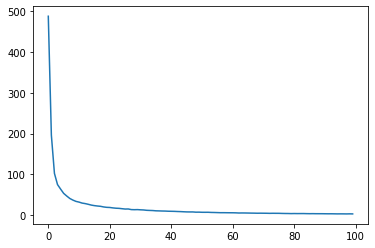

In [166]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_total_final.h5")
except (OSError, ValueError) as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_total_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [167]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

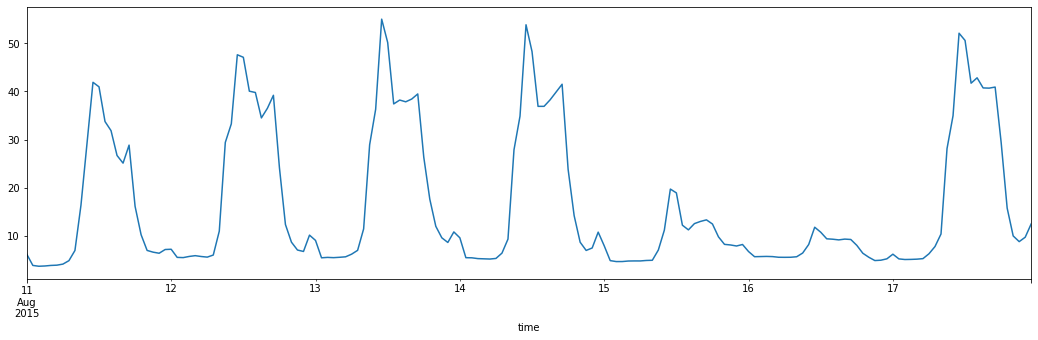

In [168]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4 + total_pred5) / 5
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred
total_pred[120:144] = total_pred2[120:144]
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18, 5))

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [169]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,6.182943,0.789800,0.717274,5.314072
2015-08-11 01:00:00,3.871565,0.591017,0.447019,4.071452
2015-08-11 02:00:00,3.701688,0.597481,0.429454,3.856618
2015-08-11 03:00:00,3.757167,0.593692,0.429577,3.799284
2015-08-11 04:00:00,3.871257,0.584003,0.447141,3.751618
...,...,...,...,...
2015-08-17 19:00:00,15.769948,1.381153,4.184873,9.298140
2015-08-17 20:00:00,9.993191,1.141569,2.336463,5.947206
2015-08-17 21:00:00,8.810398,1.114039,1.650272,5.698709
2015-08-17 22:00:00,9.727363,1.016605,1.553413,6.296342


In [170]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)